In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input, Layer, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
import random
import tensorflow as tf
import time

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='bilstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='bilstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=14, num_generations=5, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [4]:
df = pd.read_csv('/content/drive/MyDrive/PLN_Timeseries/a_442100118673_engineered.csv')
# df
# df['READ_DATE'] = pd.to_datetime(df['READ_DATE'])
# df.drop('READ_DATE_day', axis=1, inplace=True)
df.set_index('READ_DATE', inplace=True)
df

,KWH_EXP,tavg,tmin,tmax,wdir,wspd,pres,Tavg,RH_avg,RR,ss,trend,seasonal,residual
READ_DATE,,,,,,,,,,,,,,
2019-01-01,68.559507,25.7,24.8,30.2,44.0,6.4,1008.9,25.7,96.0,12.9,7.5,58.661890,-0.119942,0.007393
2019-01-02,75.451474,26.0,24.1,29.2,21.0,5.4,1009.2,25.9,90.0,42.7,6.7,58.661890,-1.196035,0.007393
2019-01-03,49.138678,24.6,24.0,27.3,340.0,4.1,1010.3,24.9,94.0,0.5,0.1,58.661890,-0.804896,0.007393
2019-01-04,78.519115,26.2,23.0,29.8,340.0,6.9,1011.4,25.8,88.0,34.6,0.1,72.296946,0.661249,5.560920
2019-01-05,82.569083,26.9,23.6,30.2,284.0,6.3,1011.7,26.7,88.0,2.1,3.2,72.627629,0.873369,9.068085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-27,100.128034,28.3,24.4,34.0,126.0,9.9,1009.9,28.7,73.0,0.0,10.4,99.590787,-0.406862,0.944109
2024-05-28,101.542578,28.2,24.1,33.9,125.0,8.0,1009.4,28.2,75.0,0.0,8.2,100.494702,-0.119942,1.167818
2024-05-29,97.339716,29.0,24.2,33.0,130.0,7.7,1009.1,29.0,77.0,0.0,10.7,58.661890,-1.196035,0.007393


In [5]:
# split data train dan test. 3 tahun pertama untuk train, 2 tahun terakhir untuk test
"""
READ_DATE
2019-01-01	11.001903	25.7	24.8	30.2	44.0	6.4	1008.9
2019-01-02	11.422662	26.0	24.1	29.2	21.0	5.4	1009.2
2019-01-03	2.341671	24.6	24.0	27.3	340.0	4.1	1010.3
2019-01-04	4.800008	26.2	23.0	29.8	340.0	6.9	1011.4
2019-01-05	5.752651	26.9	23.6	30.2	284.0	6.3	1011.7
...	...	...	...	...	...	...	...
2024-05-27	2.381903	28.3	24.4	34.0	126.0	9.9	1009.9
2024-05-28	2.412923	28.2	24.1	33.9	125.0	8.0	1009.4
2024-05-29	2.564494	29.0	24.2	33.0	130.0	7.7	1009.1
# 2024-05-30	2.558021	29.7	25.0	35.0	106.0	7.8	1009.7
2024-05-31	2.457463	29.8	25.5	35.2	121.0	9.6	1010.4
"""
train = df.loc['2019-01-01':'2022-12-31']
test = df.loc['2023-01-01':'2024-05-24']
real_sim = df.loc['2024-05-25':'2024-05-31']

In [6]:
# # Create separate scalers for features and target
# feature_scaler = StandardScaler()
# target_scaler = StandardScaler()

# train_scaled_features = feature_scaler.fit_transform(train)
# train_scaled_features = pd.DataFrame(train_scaled_features, columns=train.columns, index=train.index)

# test_scaled_features = feature_scaler.transform(test)
# test_scaled_features = pd.DataFrame(test_scaled_features, columns=test.columns, index=test.index)

# train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
# test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [7]:
# Scale data
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

train_scaled_features = feature_scaler.fit_transform(train)
train_scaled_target = target_scaler.fit_transform(train[['KWH_EXP']])
test_scaled_features = feature_scaler.transform(test)
test_scaled_target = target_scaler.transform(test[['KWH_EXP']])


In [8]:
train_scaled_features

array([[ 3.04525240e-01, -1.71819700e+00,  1.02028777e+00, ...,
         1.25039513e-02, -1.50010021e-01, -4.63843279e-04],
       [ 5.08584016e-01, -1.43304526e+00,  4.69102779e-01, ...,
         1.25039513e-02, -1.50038929e+00, -4.63843279e-04],
       [-2.70490653e-01, -2.76375338e+00,  3.90362067e-01, ...,
         1.25039513e-02, -1.00955298e+00, -4.63843279e-04],
       ...,
       [-1.35449529e+00, -1.52809584e+00,  5.47843491e-01, ...,
        -1.36863748e+00, -1.00955298e+00,  3.97963368e-03],
       [-1.43504362e+00, -1.52809584e+00,  3.90362067e-01, ...,
        -1.41303821e+00,  8.30298517e-01, -4.19004583e-01],
       [-1.39150886e+00, -1.97387720e-01,  1.02028777e+00, ...,
        -1.44378305e+00,  1.09648647e+00, -6.73534936e-02]])

In [9]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 7]  # 1 hari, 3 hari, 1 minggu

# Run GA for feature selection for each timestep
best_chromosomes_bilstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1]), array([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]), array([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0]), array([1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0]), array([0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0]), array([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1]), array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0]), array([0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]), array([1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0]), array([1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]), array([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]), array([1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1]), array([1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
Epoch 9: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Evaluating chromosome [0 1 1 0 1 0 0 1 0 0 1 0 0 1] -> MSE: 0.9180831129694605, MAE: 0.7733620809876073, R²: 0.08248700249688368, MAPE: 1.461654

In [10]:
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=7):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Limit scope to the last part of the data
    scope_start = max(0, len(combined_actual) - (n_future + 28))
    scoped_actual = combined_actual[scope_start:]
    scoped_predicted = combined_predicted[scope_start:]

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(scoped_actual)), scoped_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(scoped_predicted)), scoped_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future (Zoomed In)')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")



def train_and_plot_bilstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        Bidirectional(LSTM(128, return_sequences=True)),
        Bidirectional(LSTM(64)),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="bilstm", real_sim=real_sim, n_future=7)


In [11]:
print(best_chromosomes_bilstm.keys())

dict_keys([1, 3, 7])



Training model with selected features and timesteps = 1
Selected features: Index(['KWH_EXP', 'tmax', 'wdir', 'wspd', 'Tavg', 'RR', 'trend', 'seasonal',
       'residual'],
      dtype='object')
Epoch 23: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


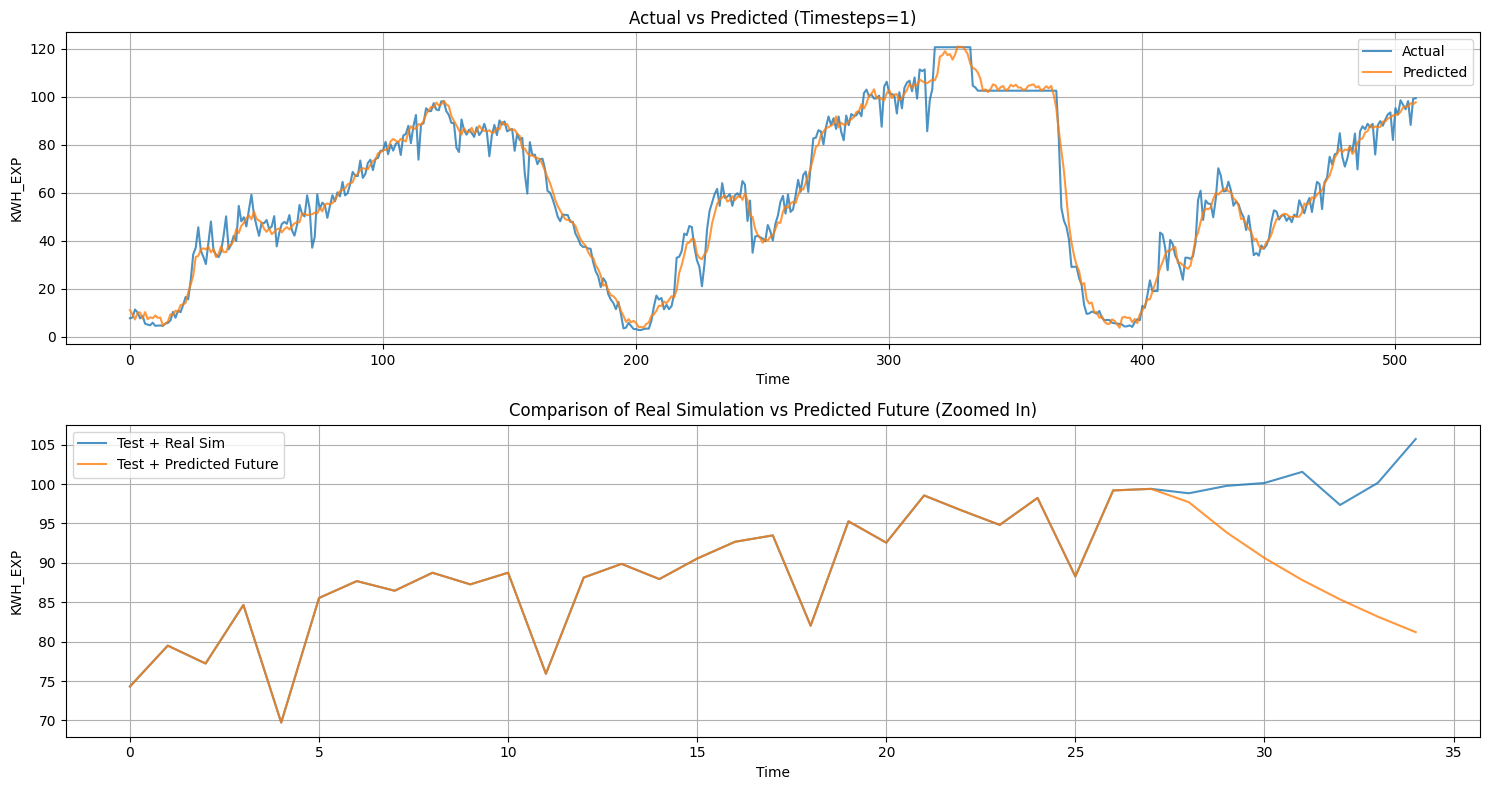


Metrics for timesteps=1:
MSE: 23.8494
R²: 0.9770
MAPE: 0.1105
MAE: 3.5074
Training time for timesteps = 1: 7.46 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'pres', 'Tavg', 'RR', 'ss', 'trend',
       'residual'],
      dtype='object')
Epoch 13: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Results saved to bilstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


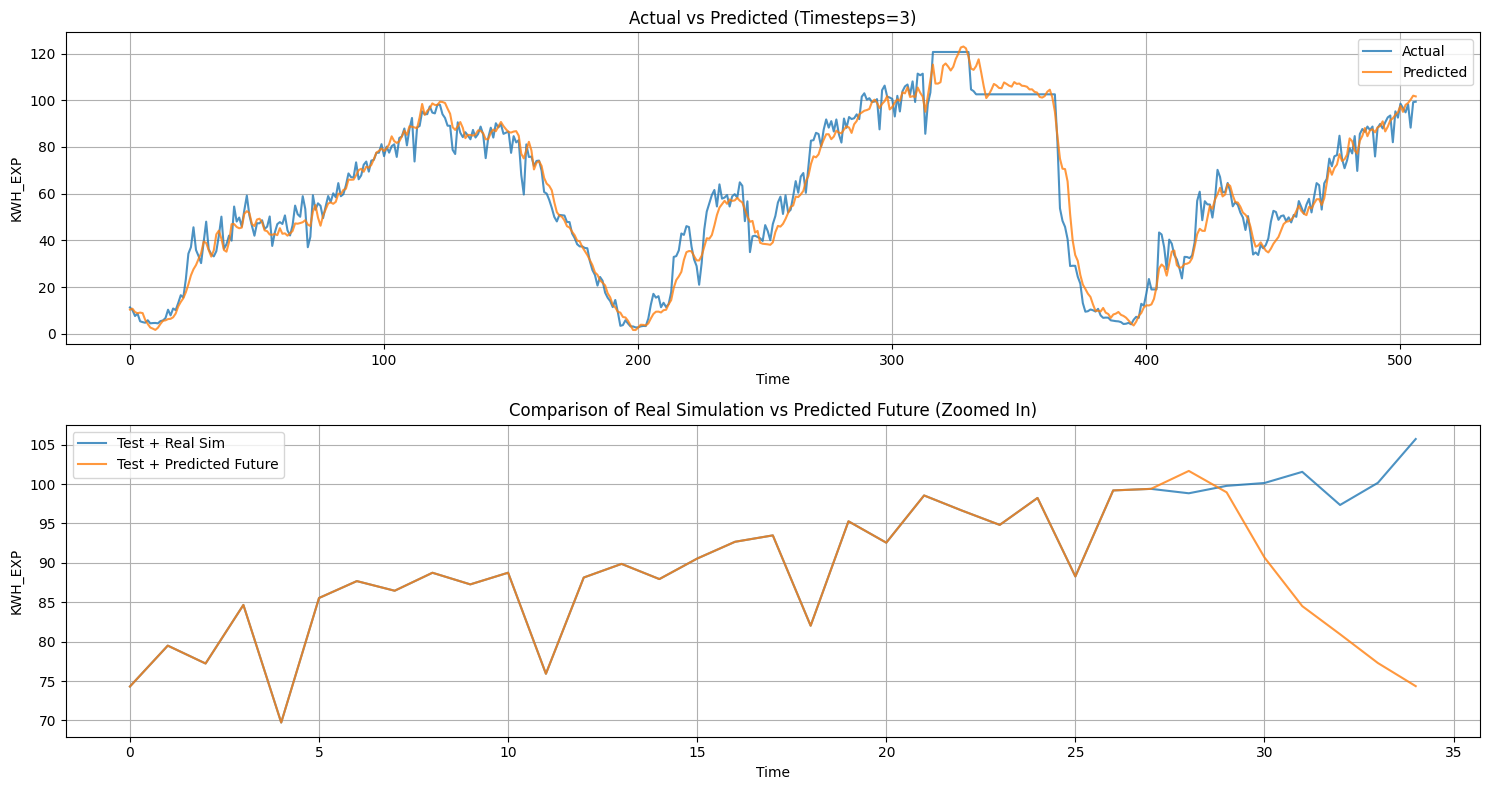


Metrics for timesteps=3:
MSE: 34.2912
R²: 0.9667
MAPE: 0.1188
MAE: 4.2437
Training time for timesteps = 3: 6.77 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'Tavg', 'RR', 'ss', 'trend',
       'seasonal', 'residual'],
      dtype='object')
Epoch 25: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Results saved to bilstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


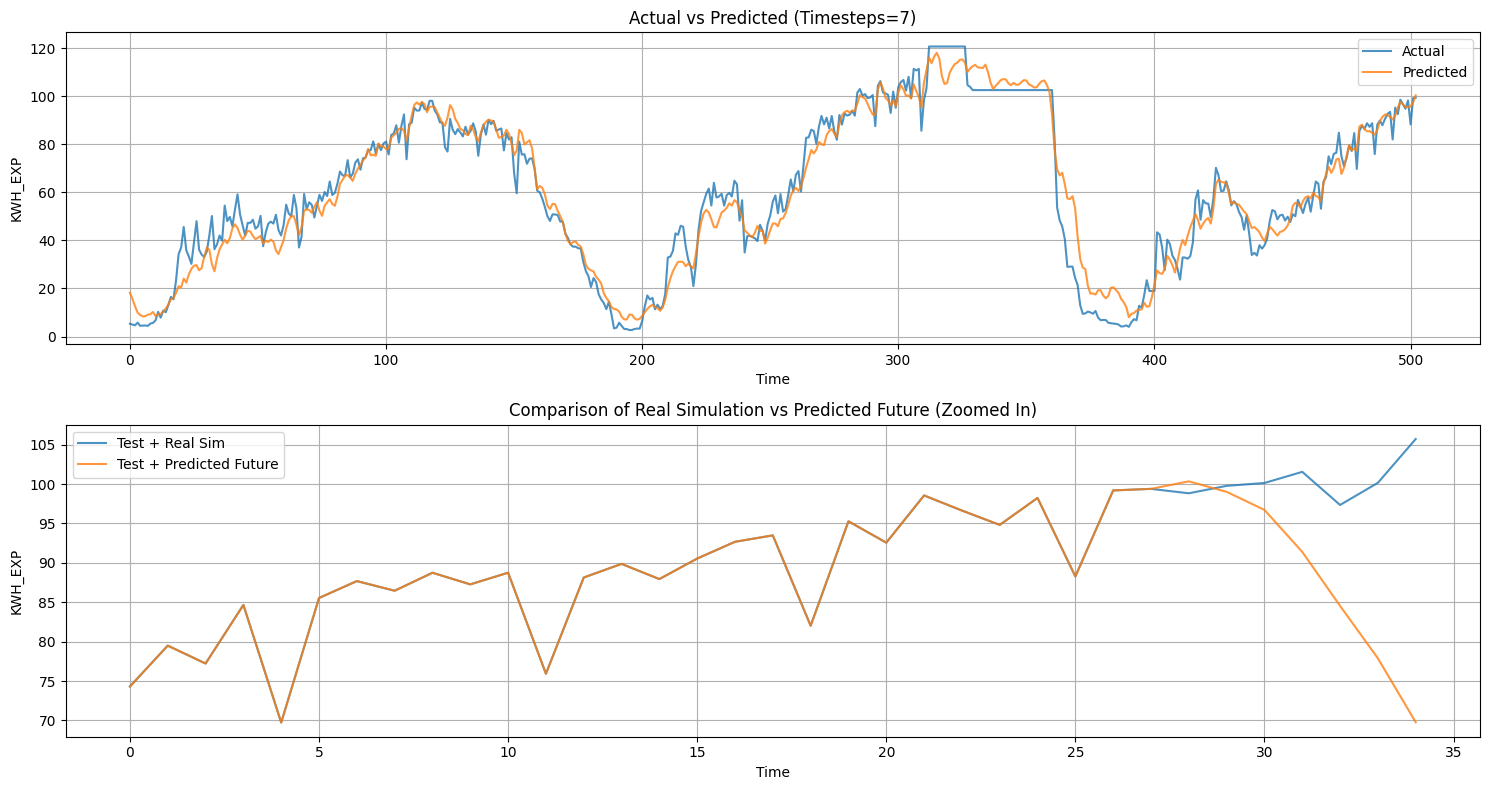


Metrics for timesteps=7:
MSE: 52.0899
R²: 0.9488
MAPE: 0.2284
MAE: 5.3763
Training time for timesteps = 7: 8.21 seconds
Total training execution time: 22.44 seconds


In [12]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_bilstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_bilstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [13]:
# Fungsi untuk membuat model LSTM atau BiLSTM
def create_model(input_shape, model_type='lstm'):
    model = Sequential()
    model.add(Input(shape=input_shape))
    if model_type == 'bilstm':
        model.add(Bidirectional(LSTM(128, return_sequences=True)))
        model.add(Bidirectional(LSTM(64)))
    else:
        model.add(LSTM(128, return_sequences=True))
        model.add(LSTM(64))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Fungsi untuk membuat dataset dengan timestep
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Fungsi untuk evaluasi kromosom
def evaluate_chromosome(chromosome, X_train, y_train, X_test, y_test, timesteps, model_type='lstm'):
    selected_features = [i for i in range(len(chromosome)) if chromosome[i] == 1]
    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    X_train_t, y_train_t = create_dataset(X_train_selected, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test_selected, y_test, timesteps)

    model = create_model((X_train_t.shape[1], X_train_t.shape[2]), model_type)
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)

    model.fit(X_train_t, y_train_t, epochs=10, validation_split=0.1, callbacks=[early_stopping], verbose=0)
    y_pred = model.predict(X_test_t)
    mse = mean_squared_error(y_test_t, y_pred)
    mae = mean_absolute_error(y_test_t, y_pred)
    r2 = r2_score(y_test_t, y_pred)
    mape = mean_absolute_percentage_error(y_test_t, y_pred)

    print(f"Evaluating chromosome {chromosome} -> MSE: {mse}, MAE: {mae}, R²: {r2}, MAPE: {mape}")
    return mse

# Fungsi untuk inisialisasi populasi
def initialize_population(pop_size, num_features):
    population = [np.random.randint(2, size=num_features) for _ in range(pop_size - 1)]
    # Tambahkan satu kromosom yang memiliki semua fitur diaktifkan
    population.append(np.ones(num_features, dtype=int))
    print(f"Initialized population: {population}")
    return population

# Fungsi untuk seleksi
def select(population, fitnesses, num_parents):
    indices = np.argsort(fitnesses)[:num_parents]
    parents = [population[i] for i in indices]
    print(f"Selected parents: {parents}")
    return parents

# Fungsi untuk crossover
def crossover(parents, offspring_size):
    offspring = []
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(list(parents), 2)
        crossover_point = random.randint(1, len(parent1)-1)
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring.append(child)
        print(f"Crossover between {parent1} and {parent2} at {crossover_point} -> {child}")
    return offspring

# Fungsi untuk mutasi
def mutate(offspring, mutation_rate):
    for child in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(child)-1)
            child[mutation_point] = 1 - child[mutation_point]
            print(f"Mutated child {child} at {mutation_point}")
    return offspring

# Main GA function
def genetic_algorithm(X, y, timesteps_list, pop_size=14, num_generations=5, mutation_rate=0.1):
    num_features = X.shape[1]
    best_chromosomes = {}
    total_start_time = time.time()

    for timesteps in timesteps_list:
        print(f"\nRunning GA for feature selection with timesteps = {timesteps}")
        population = initialize_population(pop_size, num_features)
        start_time = time.time()

        for generation in range(num_generations):
            generation_start_time = time.time()
            fitnesses = np.array([evaluate_chromosome(chrom, X, y, X, y, timesteps) for chrom in population])
            best_fitness = np.min(fitnesses)
            best_chromosome = population[np.argmin(fitnesses)]

            parents = select(population, fitnesses, pop_size//2)
            offspring = crossover(parents, pop_size - len(parents))
            offspring = mutate(offspring, mutation_rate)
            population = np.concatenate((parents, offspring))

            generation_end_time = time.time()
            print(f"Generation {generation}: Best Fitness = {best_fitness}")
            print(f"Best Chromosome: {best_chromosome}")
            print(f"Population: {population}")
            print(f"Execution time for generation {generation}: {generation_end_time - generation_start_time:.2f} seconds")

        end_time = time.time()
        best_chromosomes[timesteps] = best_chromosome
        print(f"Best Features for timesteps = {timesteps}: {best_chromosome}")
        print(f"Execution time for timesteps {timesteps}: {end_time - start_time:.2f} seconds")

    total_end_time = time.time()
    print(f"Total execution time for GA: {total_end_time - total_start_time:.2f} seconds")

    return best_chromosomes

In [14]:
def train_and_plot_lstm(X_train, y_train, X_test, y_test, timesteps, real_sim):
    def create_dataset(X, y, time_steps=1):
      Xs, ys = [], []
      for i in range(len(X) - time_steps):
          v = X[i:(i + time_steps)]
          Xs.append(v)
          ys.append(y[i + time_steps])
      return np.array(Xs), np.array(ys)

    X_train_t, y_train_t = create_dataset(X_train, y_train, timesteps)
    X_test_t, y_test_t = create_dataset(X_test, y_test, timesteps)

    model = Sequential([
        Input(shape=(timesteps, X_train.shape[1])),
        LSTM(128, return_sequences=True),
        LSTM(64),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mean_squared_error')

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        mode='min',
        verbose=1
    )

    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=2,
        min_lr=0.001,
        verbose=1
    )

    model.fit(
        X_train_t,
        y_train_t,
        validation_split=0.1,
        epochs=50,
        batch_size=512,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )

    plot_predictions(model, X_test_t, y_test_t, target_scaler, timesteps, model_name="lstm", real_sim=real_sim, n_future=7)


In [15]:
# Daftar timestep yang akan diuji
timesteps_list = [1, 3, 7]  # 1 hari, 3 hari, 1 minggu

# Run GA for feature selection for each timestep
best_chromosomes_lstm = genetic_algorithm(train_scaled_features, train_scaled_target.ravel(), timesteps_list)


Running GA for feature selection with timesteps = 1
Initialized population: [array([0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1]), array([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0]), array([0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1]), array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1]), array([0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1]), array([0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1]), array([1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0]), array([0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1]), array([0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0]), array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0]), array([1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0]), array([0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0]), array([0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])]
Epoch 10: early stopping
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Evaluating chromosome [0 0 1 0 0 0 1 0 1 1 1 1 1 1] -> MSE: 0.03992572633666922, MAE: 0.1358413401798507, R²: 0.9600990669241674, MAPE: 0.692101


Training model with selected features and timesteps = 1
Selected features: Index(['tavg', 'tmax', 'wdir', 'wspd', 'pres', 'Tavg', 'RH_avg', 'RR', 'ss',
       'trend', 'seasonal', 'residual'],
      dtype='object')
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_1_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


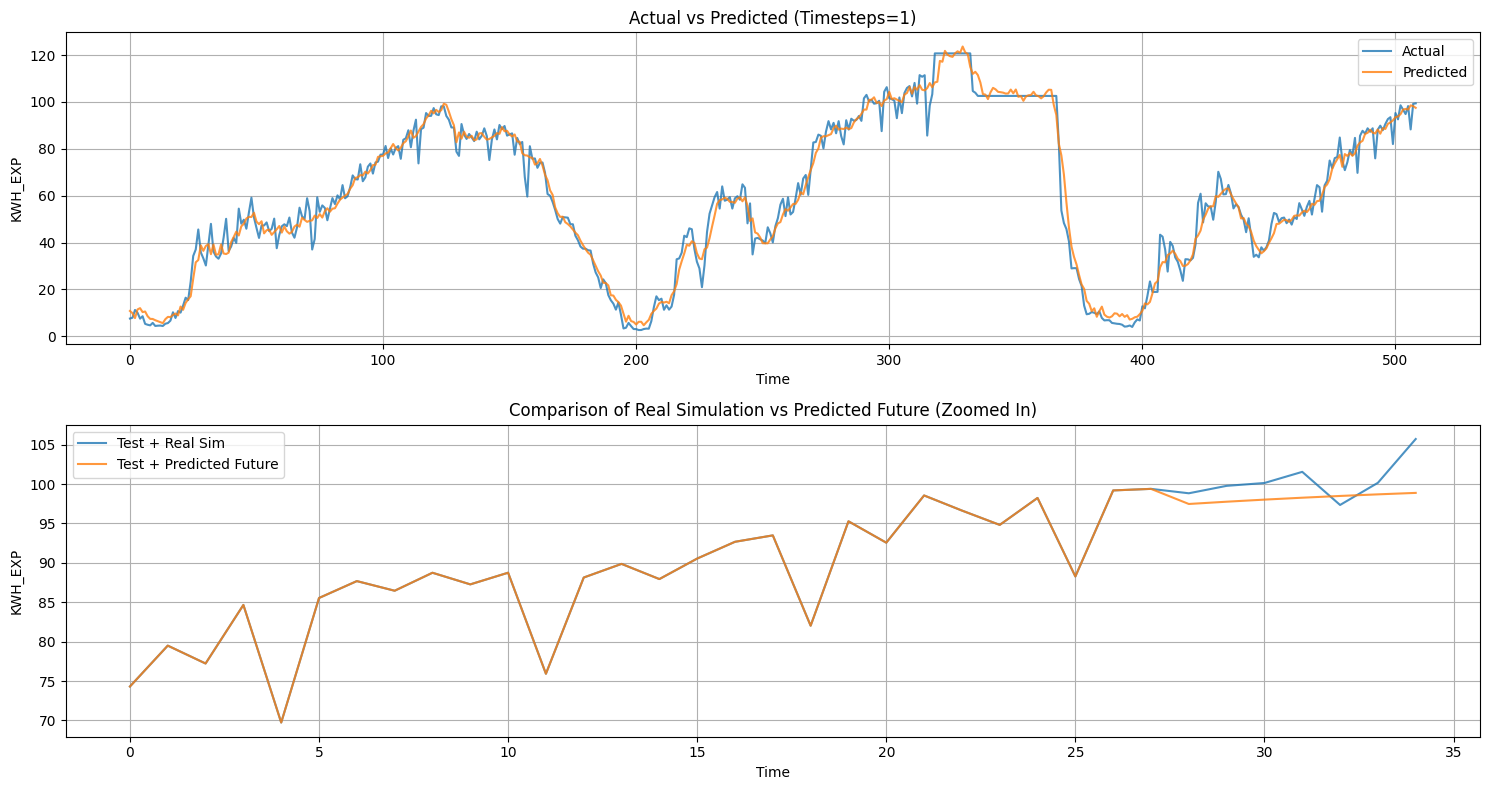


Metrics for timesteps=1:
MSE: 23.4251
R²: 0.9774
MAPE: 0.1228
MAE: 3.4940
Training time for timesteps = 1: 6.42 seconds

Training model with selected features and timesteps = 3
Selected features: Index(['KWH_EXP', 'tavg', 'tmin', 'tmax', 'wdir', 'wspd', 'Tavg', 'RR', 'ss',
       'trend', 'seasonal', 'residual'],
      dtype='object')
Epoch 17: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Results saved to lstm_timestep_3_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


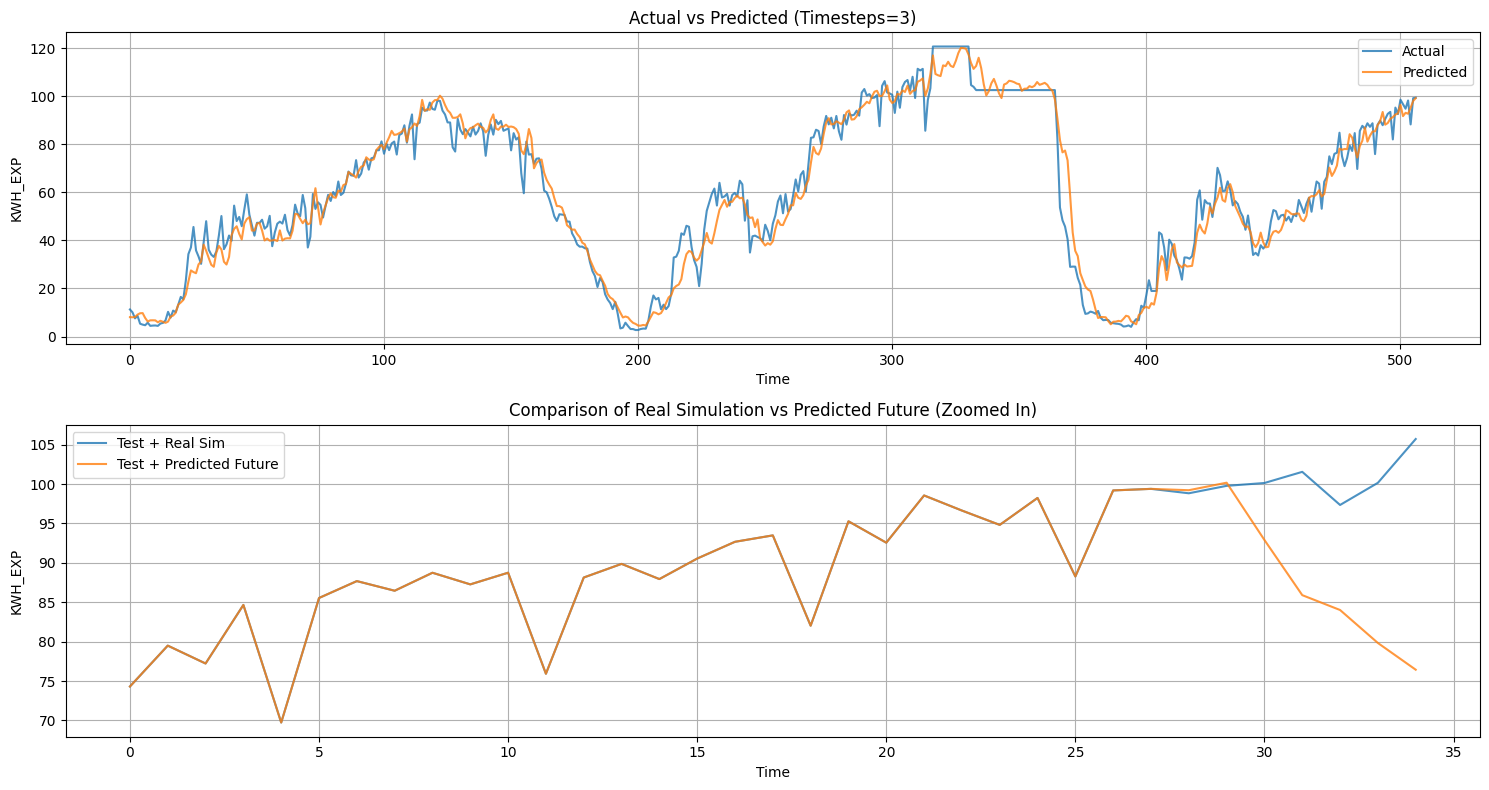


Metrics for timesteps=3:
MSE: 41.5830
R²: 0.9596
MAPE: 0.1361
MAE: 4.6300
Training time for timesteps = 3: 5.96 seconds

Training model with selected features and timesteps = 7
Selected features: Index(['KWH_EXP', 'tavg', 'tmax', 'wdir', 'pres', 'Tavg', 'RH_avg', 'trend',
       'seasonal', 'residual'],
      dtype='object')
Epoch 12: early stopping
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Results saved to lstm_timestep_7_actual_vs_pred.csv
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


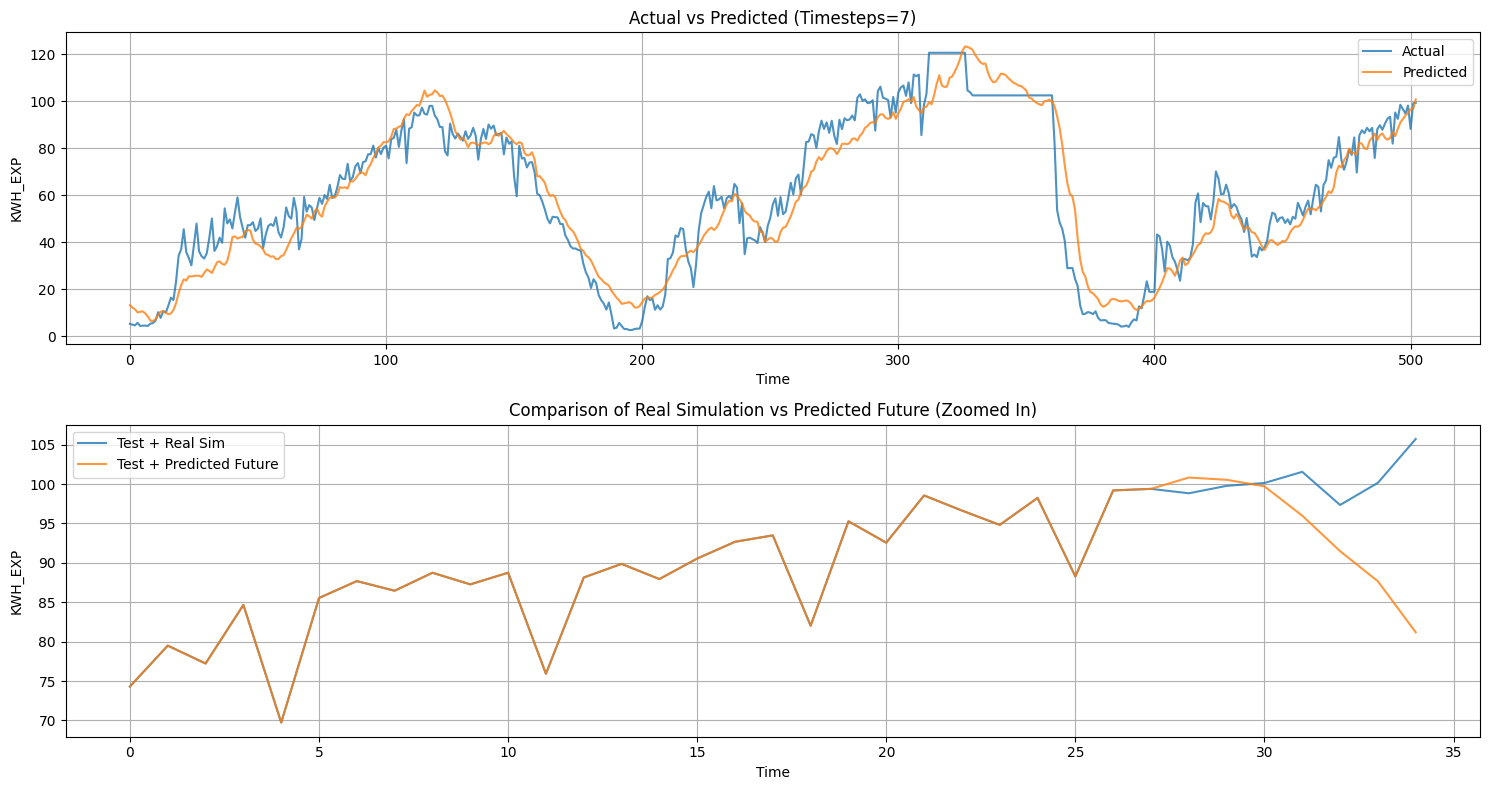


Metrics for timesteps=7:
MSE: 102.2748
R²: 0.8994
MAPE: 0.3059
MAE: 8.0366
Training time for timesteps = 7: 4.46 seconds
Total training execution time: 16.85 seconds


In [16]:
# Integrate with existing training scheme
total_training_start_time = time.time()
for ts in timesteps_list:
    best_features = best_chromosomes_lstm[ts]
    selected_features = [i for i in range(len(best_features)) if best_features[i] == 1]
    selected_feature_names = train.columns[selected_features]
    train_scaled_features_selected = train_scaled_features[:, selected_features]
    test_scaled_features_selected = test_scaled_features[:, selected_features]

    print(f"\nTraining model with selected features and timesteps = {ts}")
    print(f"Selected features: {selected_feature_names}")
    training_start_time = time.time()
    train_and_plot_lstm(train_scaled_features_selected, train_scaled_target.ravel(), test_scaled_features_selected, test_scaled_target.ravel(), ts, real_sim)
    training_end_time = time.time()
    print(f"Training time for timesteps = {ts}: {training_end_time - training_start_time:.2f} seconds")

total_training_end_time = time.time()
print(f"Total training execution time: {total_training_end_time - total_training_start_time:.2f} seconds")

In [17]:
# not zoom in
"""
def plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):
    # Make predictions
    y_pred = model.predict(X_test_t)
    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    # Create DataFrame for Actual vs Predicted
    results_df = pd.DataFrame({
        'Actual': y_test_orig.flatten(),
        'Predicted': y_pred_orig.flatten()
    })

    # Save DataFrame to CSV with model name and timesteps
    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"
    results_df.to_csv(file_name, index=False)
    print(f"Results saved to {file_name}")

    # Plot Actual vs Predicted
    plt.figure(figsize=(15, 8))
    plt.subplot(2, 1, 1)
    plt.plot(results_df['Actual'], label='Actual', alpha=0.8)
    plt.plot(results_df['Predicted'], label='Predicted', alpha=0.8)
    plt.title(f'Actual vs Predicted (Timesteps={timesteps})')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

        # Print metrics
    mse = mean_squared_error(y_test_orig, y_pred_orig)
    r2 = r2_score(y_test_orig, y_pred_orig)
    mape = mean_absolute_percentage_error(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    print(f"\nMetrics for timesteps={timesteps}:")
    print(f"MSE: {mse:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")
    print(f"MAE: {mae:.4f}")

    # Generate future predictions
    last_sequence = X_test_t[-1:]
    future_pred = []

    for _ in range(n_future):
        next_pred = model.predict(last_sequence)
        future_pred.append(next_pred[0])

        last_sequence = np.roll(last_sequence, -1, axis=1)
        last_sequence[0, -1] = next_pred[0]

    future_pred = target_scaler.inverse_transform(np.array(future_pred).reshape(-1, 1))

    # Combine test + real_sim and test + n_future predictions
    combined_actual = np.concatenate((y_test_orig.flatten(), real_sim['KWH_EXP'].values))
    combined_predicted = np.concatenate((y_test_orig.flatten(), future_pred.flatten()))

    # Plot Comparison
    plt.subplot(2, 1, 2)
    plt.plot(range(len(combined_actual)), combined_actual, label='Test + Real Sim', alpha=0.8)
    plt.plot(range(len(combined_predicted)), combined_predicted, label='Test + Predicted Future', alpha=0.8)
    plt.title('Comparison of Real Simulation vs Predicted Future')
    plt.xlabel('Time')
    plt.ylabel('KWH_EXP')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
  """

'\ndef plot_predictions(model, X_test_t, y_test_t, scaler, timesteps, model_name, real_sim, n_future=48):\n    # Make predictions\n    y_pred = model.predict(X_test_t)\n    y_test_orig = target_scaler.inverse_transform(y_test_t.reshape(-1, 1))\n    y_pred_orig = target_scaler.inverse_transform(y_pred)\n\n    # Create DataFrame for Actual vs Predicted\n    results_df = pd.DataFrame({\n        \'Actual\': y_test_orig.flatten(),\n        \'Predicted\': y_pred_orig.flatten()\n    })\n\n    # Save DataFrame to CSV with model name and timesteps\n    file_name = f"{model_name}_timestep_{timesteps}_actual_vs_pred.csv"\n    results_df.to_csv(file_name, index=False)\n    print(f"Results saved to {file_name}")\n\n    # Plot Actual vs Predicted\n    plt.figure(figsize=(15, 8))\n    plt.subplot(2, 1, 1)\n    plt.plot(results_df[\'Actual\'], label=\'Actual\', alpha=0.8)\n    plt.plot(results_df[\'Predicted\'], label=\'Predicted\', alpha=0.8)\n    plt.title(f\'Actual vs Predicted (Timesteps={timestep